## Install Dependencies

In [1]:
seed_value = 123
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

In [2]:
pip install wfdb wget tqdm biosppy imbalanced-learn seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip uninstall matplotlib --yes
!pip install matplotlib==3.1.3 

Found existing installation: matplotlib 3.1.3
Uninstalling matplotlib-3.1.3:
  Successfully uninstalled matplotlib-3.1.3
  Using cached matplotlib-3.1.3-cp39-cp39-macosx_11_0_arm64.whl


## Importing Libraries

In [4]:
# seed_value = 123
# import os
# os.environ['PYTHONHASHSEED']=str(seed_value)

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import wget
import math
import zipfile
import wfdb as wf
import pickle
import sys
import datetime
import cv2
import random
from scipy import signal
from scipy.signal import resample
from scipy.signal import find_peaks
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [6]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(seed_value)
   tf.random.set_seed(seed_value)
   np.random.seed(seed_value)
   random.seed(seed_value)

In [7]:
np.random.seed(seed_value)
vec = np.random.randint(1, 10)
print(vec)
random.seed(123)
print(random.random())
tf.random.set_seed(123)
print(tf.random.uniform([1])) 

3
0.052363598850944326
tf.Tensor([0.12615311], shape=(1,), dtype=float32)


## Extracting Data

In [8]:
module = os.path.abspath('./WESAD/')
if module not in sys.path:
    sys.path.append(module)
from DataManager import DataManager

## Data Preprocessing

In [9]:
# config
debug = False;

In [10]:
# subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

In [11]:
test_subject = [2]
rest_subjects = [3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

In [12]:
def generateData(subject_ids):
    data = DataManager()
    all_subject_data = np.array([]);
    all_subject_labels = np.array([]);

#     subject_ids = [2, 3]

    for subject_id in subject_ids:
        if(debug): print("Processing subject id: ", subject_id);
        subject = data.load(subject_id)


        if(debug):
            print('baseline: ', subject[0], '\nstress: ', subject[1], '\namusement: ', subject[2], '\nbase_label: ', subject[3], '\nstress_label: ', subject[4], '\namuse_label: ', subject[5])

        ecg_base = subject[0]
        ecg_stress = subject[1]
        ecg_amusement = subject[2]

        base_label = subject[3]
        stress_label = subject[4]
        amuse_label = subject[5]

        ecg_base_T = ecg_base.T
        ecg_stress_T = ecg_stress.T
        ecg_amusement_T = ecg_amusement.T

        ecg_base_data = ecg_base_T[0]
        ecg_stress_data = ecg_stress_T[0]
        ecg_amusement_data = ecg_amusement_T[0]

        ecg_base_label =  base_label.T
        ecg_stress_label  = stress_label.T
        ecg_amusement_label  = amuse_label.T

        if(debug):
            print('ecg_base_data:', ecg_base_data)
            print('ecg_stress_data:', ecg_stress_data)
            print('ecg_amusement_data:', ecg_amusement_data)

            print('ecg_base_label:', ecg_base_label)
            print('ecg_stress_label:', ecg_stress_label)
            print('ecg_amusement_label:', ecg_amusement_label)


        base_secs = len(ecg_base_data) // 700 # Number of seconds in signal X
        base_samps = int(base_secs * 256 )    # Number of samples to downsample
        base_down = signal.resample(ecg_base_data, base_samps)


        stress_secs = len(ecg_stress_data) // 700 # Number of seconds in signal X
        stress_samps = int(stress_secs * 256 )    # Number of samples to downsample
        stress_down = signal.resample(ecg_stress_data, stress_samps)


        amuse_secs = len(ecg_amusement_data) // 700 # Number of seconds in signal X
        amuse_samps = int(amuse_secs * 256 )    # Number of samples to downsample
        amuse_down = signal.resample(ecg_amusement_data, amuse_samps)

    #     heart_beat_base = np.array_split(base_down, 256)
    #     heart_beat_stress = np.array_split(stress_down, 256)
    #     heart_beat_amuse = np.array_split(amuse_down, 256)

        window_size = 256
        window_shift = 256

        heart_beat_base = []
        for i in range(0,len(base_down) - window_size,window_shift):
            heart_beat_base.append(base_down[i:window_size + i])
        heart_beat_base.pop()
    #     heart_beat_base = np.array(list(heart_beat_base[:]), dtype=float)

        heart_beat_stress = []
        for i in range(0,len(stress_down) - window_size,window_shift):
            heart_beat_stress.append(stress_down[i:window_size + i])
        heart_beat_stress.pop()
    #     heart_beat_stress = np.array(list(heart_beat_stress[:]), dtype=float)

        heart_beat_amuse = []
        for i in range(0,len(amuse_down) - window_size,window_shift):
            heart_beat_amuse.append(amuse_down[i:window_size + i])
        heart_beat_amuse.pop()
    #     heart_beat_amuse = np.array(list(heart_beat_amuse[:]), dtype=float)


        for idx, idxval in enumerate(heart_beat_base):
            heart_beat_base[idx] = (heart_beat_base[idx] - heart_beat_base[idx].min()) / heart_beat_base[idx].ptp() # Normalize the readings to a 0-1 range 
            heart_beat_base[idx] = np.append(heart_beat_base[idx], 0.0) #Baseline = 0

        for idx, idxval in enumerate(heart_beat_stress):
            heart_beat_stress[idx] = (heart_beat_stress[idx] - heart_beat_stress[idx].min()) / heart_beat_stress[idx].ptp() # Normalize the readings to a 0-1 range 
            heart_beat_stress[idx] = np.append(heart_beat_stress[idx], 1.0) #Stress = 1    

        for idx, idxval in enumerate(heart_beat_amuse):
            heart_beat_amuse[idx] = (heart_beat_amuse[idx] - heart_beat_amuse[idx].min()) / heart_beat_amuse[idx].ptp() # Normalize the readings to a 0-1 range 
            heart_beat_amuse[idx] = np.append(heart_beat_amuse[idx], 2.0) #Amusement = 2

    #     print("heart_beat_base:", len(heart_beat_base[0]), len(heart_beat_base[-2]), len(heart_beat_base[-1]))
    #     print("heart_beat_stress:", len(heart_beat_stress[0]), len(heart_beat_stress[-1]))
    #     print("heart_beat_amuse:", len(heart_beat_amuse[0]), len(heart_beat_amuse[-1]))

        heart_beat_all = np.concatenate((heart_beat_base, heart_beat_stress, heart_beat_amuse), axis=0)
        subject_data = np.array(list(heart_beat_all[:]), dtype=float)


        if(all_subject_data.size == 0):
            all_subject_data = subject_data
        else:
            if(subject_data.size != 0):
                all_subject_data = np.concatenate((all_subject_data, subject_data), axis=0)

        print("New data shape", subject_data.shape, "Total Shape: ", all_subject_data.shape)
        
    #SMOTE to balance the data
    df_final_data_X = pd.DataFrame(data=all_subject_data[:, :-1])
    df_final_data_Y = pd.DataFrame(data=all_subject_data[:,-1])

    smote = SMOTE(sampling_strategy='not majority')
    X_sm, y_sm = smote.fit_resample(df_final_data_X, df_final_data_Y)
    
    return X_sm, y_sm

## Data Generation - Train

In [13]:
train_data, train_labels = generateData(rest_subjects)

Loading data for S3
New data shape (2149, 257) Total Shape:  (2149, 257)
Loading data for S4
New data shape (2159, 257) Total Shape:  (4308, 257)
Loading data for S5
New data shape (2211, 257) Total Shape:  (6519, 257)
Loading data for S6
New data shape (2196, 257) Total Shape:  (8715, 257)
Loading data for S7
New data shape (2192, 257) Total Shape:  (10907, 257)
Loading data for S8
New data shape (2202, 257) Total Shape:  (13109, 257)
Loading data for S9
New data shape (2191, 257) Total Shape:  (15300, 257)
Loading data for S10
New data shape (2271, 257) Total Shape:  (17571, 257)
Loading data for S11
New data shape (2222, 257) Total Shape:  (19793, 257)
Loading data for S13
New data shape (2220, 257) Total Shape:  (22013, 257)
Loading data for S14
New data shape (2221, 257) Total Shape:  (24234, 257)
Loading data for S15
New data shape (2227, 257) Total Shape:  (26461, 257)
Loading data for S16
New data shape (2215, 257) Total Shape:  (28676, 257)
Loading data for S17
New data shape 

In [14]:
train_labels.value_counts()

0.0    16439
1.0    16439
2.0    16439
dtype: int64

In [15]:
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Dimension:", train_labels.ndim)

Train data shape: (49317, 256)
Train labels shape: (49317, 1)
Dimension: 2


In [16]:
train_labels = pd.DataFrame(train_labels).to_numpy()
train_labels = train_labels.reshape(-1)

In [17]:
print("Train labels shape:", train_labels.shape)
print("Dimension:", train_labels.ndim)

Train labels shape: (49317,)
Dimension: 1


## Train and Validation data split

In [18]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.3, random_state=123)

In [19]:
#Reshape train and validation data to (n_samples, 256, 1), where each sample is of size (256, 1)
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

In [20]:
print('size of X_train:', X_train.shape)
print('size of X_val:', X_val.shape)

print('size of y_train:', y_train.shape)
print('size of y_val:', y_val.shape)

print('Train:', Counter(y_train), '\nVal:', Counter(y_val))

size of X_train: (34521, 256, 1)
size of X_val: (14796, 256, 1)
size of y_train: (34521,)
size of y_val: (14796,)
Train: Counter({0.0: 11578, 2.0: 11487, 1.0: 11456}) 
Val: Counter({1.0: 4983, 2.0: 4952, 0.0: 4861})


## Data Generation - Test

In [21]:
test_data, test_labels = generateData(test_subject)

Loading data for S2
New data shape (2115, 257) Total Shape:  (2115, 257)


In [22]:
test_labels.value_counts()

0.0    1142
1.0    1142
2.0    1142
dtype: int64

In [23]:
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)
print("Dimension:", test_labels.ndim)

Test data shape: (3426, 256)
Test labels shape: (3426, 1)
Dimension: 2


In [24]:
test_labels = pd.DataFrame(test_labels).to_numpy()
y_test = test_labels.reshape(-1)

In [25]:
print("Test labels shape:", y_test.shape)
print("Dimension:", y_test.ndim)

Test labels shape: (3426,)
Dimension: 1


In [26]:
#Reshape test data to (n_samples, 256, 1), where each sample is of size (256, 1)
X_test = np.array(test_data).reshape(test_data.shape[0], test_data.shape[1], 1)

In [27]:
print('size of X_test:', X_test.shape)
print('size of y_test:', y_test.shape)

print('Test:', Counter(y_test))

size of X_test: (3426, 256, 1)
size of y_test: (3426,)
Test: Counter({0.0: 1142, 1.0: 1142, 2.0: 1142})


## 1D CNN Model Architecture

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, BatchNormalization, MaxPool1D, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [29]:
reset_random_seeds()
initializer = tf.keras.initializers.HeUniform()
cnn_model = tf.keras.models.Sequential()
cnn_model.add(Input(shape = (X_train.shape[1],1)))
cnn_model.add(Conv1D(filters=5, kernel_size=(5,), padding='same',  activation='relu', kernel_initializer=initializer))
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Conv1D(filters=10, kernel_size=(5,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Conv1D(filters=10, kernel_size=(4,), padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(MaxPool1D(pool_size=(2,), strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units = 128, kernel_regularizer =tf.keras.regularizers.l2(l=0.004)))
cnn_model.add(Dense(units = 3, activation='softmax'))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 256, 5)            30        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 5)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 10)           260       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 10)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 10)            410       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 32, 10)            0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0

In [30]:
epochs=50
batch_size = 32

In [31]:
def step_decay(epoch):
   initial_lrate = 0.005
   drop = 0.6
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [32]:
# class LossHistory(tf.keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#        self.losses = []
#        self.lr = []
 
#     def on_epoch_end(self, batch, logs={}):
#        self.losses.append(logs.get('loss'))
#        self.lr.append(step_decay(len(self.losses)))

In [33]:
# loss_history = LossHistory()
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [loss_history, lrate]

In [34]:
opt = tf.keras.optimizers.SGD( learning_rate=0.0, momentum=0.6, nesterov=False)

cnn_model.compile(optimizer= opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
history = cnn_model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_val, y_val), callbacks=callbacks_list, verbose=2)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow t

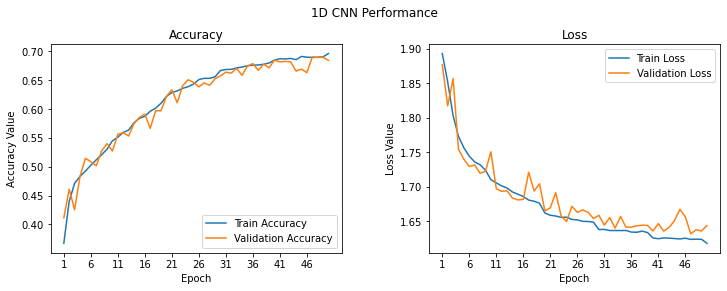

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('1D CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [37]:
cnn_model.evaluate(X_test, y_test)

108/108 [==============================] - 0s 572us/step - loss: 3.0231 - accuracy: 0.4276


[3.023097515106201, 0.4276123642921448]